In [69]:
## basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from datetime import datetime

## torch imports
import torch
import torch.nn as nn
import torchvision.transforms as torch_transforms
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

In [70]:
def disp_img_grid(*images, titles=[], n_cols=2):
    n_rows = math.ceil(len(images)/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols)

    if n_rows == 1:
        axes = axes.reshape(1,n_cols)

    r = 0
    c = 0

    for i in range(len(images)):
        axes[r,c].imshow(images[i])
        axes[r,c].axis(False)

        if(i < len(titles)):
            axes[r,c].set_title(titles[i])

        c+=1
        if (i+1)%n_cols == 0:
            r += 1
            c = 0


    plt.tight_layout()
    plt.show()

def disp_tensor_img(image):
    with torch.no_grad():
        plt.imshow(image.squeeze().permute(1,2,0))

In [71]:
## getting the images
content_img_path = "data/content_img.jpg"
style_img_path = "data/style_img.png"

content_img = Image.open(content_img_path)
style_img = Image.open(style_img_path)

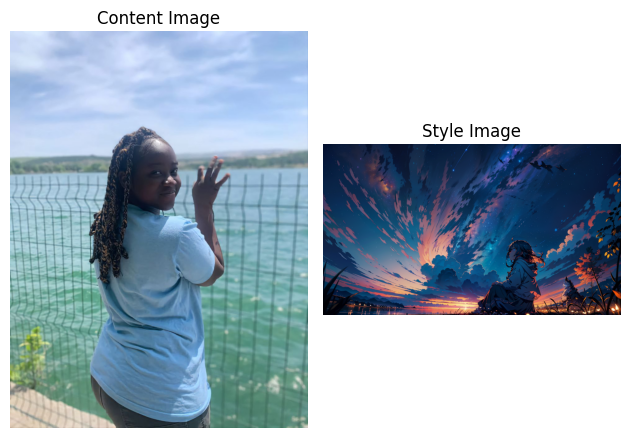

In [72]:
disp_img_grid(content_img, style_img, titles=["Content Image", "Style Image"])

In [73]:
## creating resize for content image
w, h = content_img.size
aspect_ratio = w/h
new_size = 256
c_new_shape = (new_size, int(new_size * aspect_ratio))

## creating resize for style image
w, h = style_img.size
aspect_ratio = w/h
new_size = 256
s_new_shape = (new_size, int(new_size * aspect_ratio))

In [74]:
## transforming content and style images to tensor
content_transformer = torch_transforms.Compose([
    torch_transforms.Resize(c_new_shape),
    torch_transforms.ToTensor(),
])

style_transformer = torch_transforms.Compose([
    torch_transforms.Resize(s_new_shape),
    torch_transforms.ToTensor(),
])

content_img = content_transformer(content_img)
style_img = style_transformer(style_img)

## adding fake dimensions to images
content_img = content_img.unsqueeze(0)
style_img = style_img.unsqueeze(0)

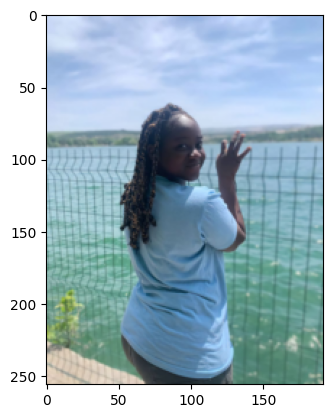

In [75]:
disp_tensor_img(content_img)

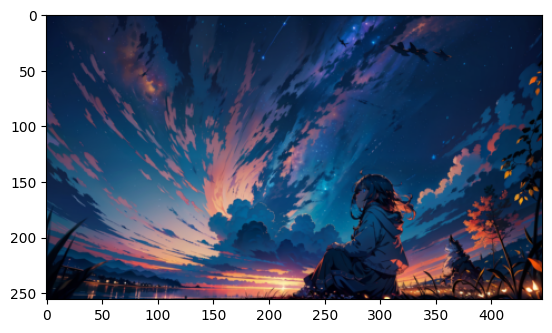

In [76]:
disp_tensor_img(style_img)

In [77]:
## getting the pre-trained model
cnn = vgg16(weights = VGG16_Weights.IMAGENET1K_FEATURES).eval().features
cnn.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [78]:
## creating losses
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target)
        self.loss = 0

    def gram_matrix(self, X):
        b,c,h,w = X.shape
        X = X.view(b*c, w*h)
        gram = X@X.T
        gram = gram.div(b*c*h*w)
        return gram

    def forward(self, X):
        self.loss =  nn.functional.mse_loss(self.gram_matrix(X), self.target)
        return X

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target
        self.loss = 0

    def forward(self,X):
        self.loss =  nn.functional.mse_loss(X, self.target)
        return X

In [79]:
## getting the necessary transforms
VGG16_Weights.IMAGENET1K_FEATURES.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.48235, 0.45882, 0.40784]
    std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
    interpolation=InterpolationMode.BILINEAR
)

In [80]:
class Model(nn.Module):
    def __init__(self, cnn, content_image, style_image, content_layers=[11], style_layers=[1,2,3,4,5]):
        self.content_layers = [f"conv_{i}" for i in content_layers]
        self.style_layers = [f"conv_{i}" for i in style_layers]
        super(Model, self).__init__()
        self.model = nn.Sequential(torch_transforms.Normalize(mean=[0.48235, 0.45882, 0.40784],
                                                              std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
                                                             ))
        self.style_losses = []
        self.content_losses = []

        conv_count = 0
        for layer in cnn:
            if isinstance(layer, nn.Conv2d):
                conv_count += 1
                name = f"conv_{conv_count}"
            elif isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
                name =  f"relu_{conv_count}"
            elif isinstance(layer, nn.MaxPool2d):
                name = f"pool_{conv_count}"
            elif isinstance(layer, nn.BatchNorm2d):
                name = f"bn{conv_count}"
            else:
                raise Exception(f"Layer of type {layer.__class__.__name__} not found")

            self.model.add_module(name, layer)
            
            if name in self.content_layers:
                target = self.model(content_image).detach()
                content_loss = ContentLoss(target)
                self.model.add_module(f"content_loss_{conv_count}", content_loss)
                self.content_losses.append(content_loss)
            if name in self.style_layers:
                target = self.model(style_image).detach()
                style_loss = StyleLoss(target)
                self.model.add_module(f"style_loss_{conv_count}", style_loss)
                self.style_losses.append(style_loss)

            if conv_count >= max(content_layers[-1], style_layers[-1]):
                break

    def forward(self, X):
        self.model(X)
        return self.content_losses, self.style_losses

In [81]:
## getting device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [82]:
model = Model(cnn, content_img, style_img)
model.to(device)

Model(
  (model): Sequential(
    (0): Normalize(mean=[0.48235, 0.45882, 0.40784], std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098])
    (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss_1): StyleLoss()
    (relu_1): ReLU()
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss_2): StyleLoss()
    (relu_2): ReLU()
    (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss_3): StyleLoss()
    (relu_3): ReLU()
    (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss_4): StyleLoss()
    (relu_4): ReLU()
    (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss_5): StyleLoss()
    (relu_5): ReLU()
 

In [83]:
%%capture
## creating input
input_img = torch.randn(content_img.shape)
input_img.requires_grad_(True)

In [84]:
# ## getting optimizer
# def get_optimizer(input_img):
#     return torch.optim.LBFGS([input_img], lr=0.1)
optimizer = torch.optim.LBFGS([input_img], lr=0.1)

In [93]:
def learn(model, input_img, optimizer, style_weight=1, epochs=50):
    run = [0]
    while run[0] <= epochs:
        t0 = [datetime.now()]
        def closure():
            optimizer.zero_grad()
            with torch.no_grad():
                input_img.clamp_(0,1)
                
            content_losses, style_losses = model(input_img)
            content_loss = 0
            style_loss = 0

            for item in content_losses:
                content_loss += item.loss
            for item in style_losses:
                style_loss += item.loss

            run[0]+=1
            if run[0]%50 == 0:
                print(t0[0])
                dt = t0[0] - datetime.now()
                print(f"Content Loss {content_loss.item()} --- Style Loss: {style_loss.item()} --- Duration: {dt}")
                t0[0] = datetime.now()

            total_loss =  content_loss + style_loss*style_weight
            total_loss.backward()

            return total_loss

        

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0,1)

In [94]:
learn(model, input_img, optimizer, epochs=500)

2024-01-27 18:42:35.363953
Content Loss 2236.670166015625 --- Style Loss: 1012.7384033203125 --- Duration: -1 day, 23:59:48.345334
2024-01-27 18:43:30.003248
Content Loss 2044.3873291015625 --- Style Loss: 871.4851684570312 --- Duration: -1 day, 23:59:33.732594
2024-01-27 18:44:49.713331
Content Loss 1887.998046875 --- Style Loss: 762.8364868164062 --- Duration: -1 day, 23:59:48.635275
2024-01-27 18:45:38.368894
Content Loss 1767.94677734375 --- Style Loss: 683.0894165039062 --- Duration: -1 day, 23:59:36.017714
2024-01-27 18:46:52.748279
Content Loss 1685.0396728515625 --- Style Loss: 620.27880859375 --- Duration: -1 day, 23:59:47.907723
2024-01-27 18:47:42.657814
Content Loss 1620.1510009765625 --- Style Loss: 573.410400390625 --- Duration: -1 day, 23:59:36.654334
2024-01-27 18:48:55.531701
Content Loss 1569.1536865234375 --- Style Loss: 538.039306640625 --- Duration: -1 day, 23:59:48.265364
2024-01-27 18:49:44.330081
Content Loss 1525.994140625 --- Style Loss: 509.837646484375 --- D

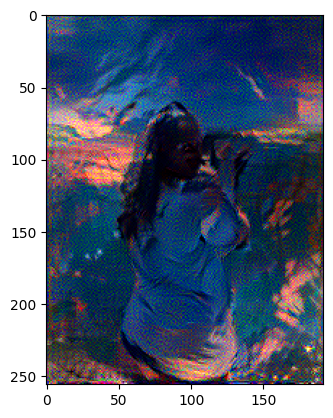

In [95]:
disp_tensor_img(input_img)